#Lab 3: Image Filtering
Task: in this lab you will create a class `GuassianFilt` this class will contain two methods of applying a guassian filter to the image. The first method `stdconv` can use a standard 2D convolution (We will use the SciPy [signal.convolve2D](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) to perform the convolution). The second method `sepconv` should use separable convolution to apply the gaussuian filter to the image.

Learning outcomes: In this lab we will demonstrate filtering of images with a gaussian kernel. We will see how to perform linear filtering of images using separable convolution which is more computationally efficient than convolution with a single large kernel.

Hints:
* Within your class build a function to output a 1D gaussian kernel for any standard deviation value $\sigma$. We will use the sampled approximation for the gaussian kernel and obtain sampled values from equation for the gaussian probabilty density function. The equation for the 1D guassian PDF with zero mean and standard deviation $\sigma$ is given [here](https://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/04%20Gaussian%20derivatives.pdf). It is necessary to obtain the kernel over a sufficient range of points, so that the function has time to decay to zero. The rule of thumb is that the range $M$ over which we need to evaluate the kernel should be $M=6\sigma+1$. We obtain values for the kernel at integer values $x$ in the over the range $x=[-M/2,M/2]$
* The 1D guassian kernel should be of size N x 1 (so it's really a 2D array), this allows you to use the Scipy signal.convolve2D method to perform convolution.
* To obtain the 2D guassian kernel (As we can see in the figure below), we get the outer product of two 1D (column) arrays $u$ and $v$ by matrix multiplying $uv^T$. The outer product of two 1D vectors (or numpy arrays) will give an (n x n) 2D array.  

![](https://media.cheggcdn.com/study/8a3/8a3993b3-d3e3-4885-a922-78c73a0f1d76/DC-1776V3.png)

* Convolution takes place separately (sequentially) with each of the 1D kernels (used to make our 2D kernel), and we will get the same result as convolution with the original 2D kernel.

![](https://iq.opengenus.org/content/images/2021/06/ssc2.PNG)


##House Keeping
Import packages

In [1]:
import numpy as np
import urllib.request
import cv2
from matplotlib import pyplot as plt
from scipy import signal
import os
import time
from urllib.parse import urlparse

Helper functions

In [2]:

image_url = "https://github.com/tonyscan6003/etivities/blob/main/2560px-Great_Sphinx_of_Giza_-_20080716a.jpg?raw=true"
# Function to read images from the Web.
def download_image(url, save_path):
    """
    Downloads an image from a URL and saves it to disk.
    If the image already exists at the specified path, it is read from disk.

    Args:
        url (str): URL of the image.
        save_path (str): Path to save the image on disk.

    Returns:
        None
    """
    # Parse the URL to get the filename
    filename = os.path.basename(urlparse(url).path)
    image_path = os.path.join(save_path, filename)

    # Check if the image already exists
    if os.path.exists(image_path):
        print(f"Image already exists at {image_path}. Reading from disk.")
        image = cv2.imread(image_path)
    else:
        print(f"Downloading image from {url}...")
        resp = urllib.request.urlopen(url)
        temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
        temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        print(f"Image downloaded and saved at {image_path}.")
        cv2.imwrite(image_path, temp_image)
        image = cv2.imread(image_path)
    return image

def read_image():
   # read Image
   sf =2
   image = download_image(image_url,save_path="./")
   #Scale Image by sf = 2
   x,y,z = np.shape(image)
   image_scale = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
   #Convert to Greyscale
   gray = cv2.cvtColor(image_scale, cv2.COLOR_BGR2GRAY)
   return image_scale,gray


# Create Class
In the code cell below create the class `GuassianFilt`, which applies a gaussian kernel with standard deviation $\sigma$ to any image. The first method `stdconv` that performs convolution with the 2D kernel. The second method `sepconv` performs separable convolution.

In [7]:
class GaussianFilt:
    def __init__(self, sigma):
        self.sigma = sigma

    def kernel1d(self):
        m = int(6 *self.sigma + 1)
        x = np.arange(-m//2,m//2+1,)
        G = np.exp(-(x**2) / (2 * self.sigma**2))
        G = G/np.sum(G)
        return G.reshape(-1, 1)

    def stdconv(self, img):
        G = self.kernel1d()
        K2D = G@G.T
        filter_img = signal.convolve2d(img, K2D, boundary='symm', mode='same')
        return filter_img

    def sep_conv(self, img):
        G = self.kernel1d()
        vertical = signal.convolve2d(img, G, boundary='symm', mode='same')
        horizondal = signal.convolve2d(vertical, G.T, boundary='symm', mode='same')
        return horizondal



## Evalution of Class methods

We will verify that both approaches to convolution blur the image,
We will record and display the time taken for the convolution operation in each case. We set $\sigma=10$ so the resulting kernel is large and it will take significant time to convolve this with the image due to the amount of computation. We should see a significant improvement in time with separable convolution.

Image already exists at ./2560px-Great_Sphinx_of_Giza_-_20080716a.jpg. Reading from disk.
Image already exists at ./2560px-Great_Sphinx_of_Giza_-_20080716a.jpg. Reading from disk.
Time taken to compute convolution = 11.58418083190918 seconds ---
Image already exists at ./2560px-Great_Sphinx_of_Giza_-_20080716a.jpg. Reading from disk.
Time taken to compute separable convolution = 0.9926283359527588 seconds ---


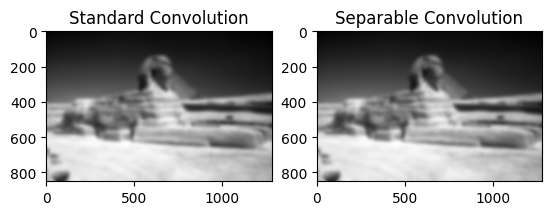

In [8]:
if __name__ == "__main__":
  # read Image
  image_scale,gray = read_image()

  # Instantiate Class
  my_gauss_filt = GaussianFilt(10)

  # load image again (to remove previous blur)
  image_scale,gray = read_image()

  # Use time method to measure how long convolution operation takes
  start_time = time.time()

  # Perform convolution with standard convolution.
  gauss_conv_img = my_gauss_filt.stdconv(gray)

  # Print Time Elaspsed
  print("Time taken to compute convolution = %s seconds ---" % (time.time() - start_time))

  # Plot result of convolution
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(gauss_conv_img,'gray')
  ax[0].set_title('Standard Convolution')


  # load image again (to remove previous blur)
  image_scale,gray = read_image()

  # Start/Record Time for Separable Convolution
  start_time = time.time()

  # Call function to perform separable convolution
  gauss_conv_img = my_gauss_filt.sep_conv(gray)

  # Print Elapsed Time and plot image
  print("Time taken to compute separable convolution = %s seconds ---" % (time.time() - start_time))
  ax[1].imshow(gauss_conv_img,'gray')
  ax[1].set_title('Separable Convolution')